In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from PIL import Image
from PIL import ImageDraw

import numpy as np

import json

from nuscenes.nuscenes import NuScenes

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

In [2]:
datasets_root = '/disk/ml/datasets/'  # Root folder for all dataset 


In [3]:
#Load nuScenes
nusc_trainval = NuScenes(version='v1.0-trainval', dataroot=datasets_root + 'nuScenes', verbose=True)
nusc_test = NuScenes(version='v1.0-test', dataroot=datasets_root + 'nuScenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 61.329 seconds.
Reverse indexing ...
Done reverse indexing in 9.3 seconds.
Loading NuScenes tables for version v1.0-test...
23 category,
8 attribute,
4 visibility,
0 instance,
12 sensor,
1800 calibrated_sensor,
462901 ego_pose,
15 log,
150 scene,
6008 sample,
462901 sample_data,
0 sample_annotation,
4 map,
Done loading in 7.398 seconds.
Reverse indexing ...
Done reverse indexing in 1.1 seconds.


In [4]:
# For nuScenes, the process is
# 1) Find "file_name": "nuscenes_xxx" in corner_case.json
# 2) Associate this file_name with the nuScenes token via nuscenes_sample_tokens.json
# 3) Get file via nuScenes sample_data.json

# Read JSONs
json_cornercases = datasets_root + 'CODA/base-val/corner_case.json'
json_tokens = datasets_root + 'CODA/base-val/nuscenes_sample_tokens.json'
json_kitti = datasets_root + 'CODA/base-val/kitti_indices.json'

with open(json_cornercases, 'r') as f:
  data_cornercases = json.load(f)

with open(json_tokens, 'r') as f:
  data_tokens = json.load(f)

with open(json_kitti, 'r') as f:  
  data_kitti = json.load(f)

annotations = data_cornercases["annotations"]
images = data_cornercases["images"]
categories = data_cornercases["categories"]

  0%|          | 0/1000 [00:00<?, ?it/s]

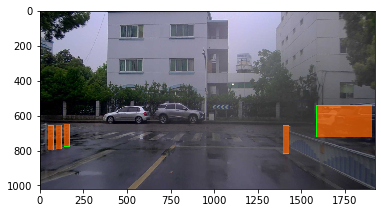

100%|██████████| 1000/1000 [00:01<00:00, 820.66it/s]

# KITTI: 0 Categories: 0
# nuScenes: 0 Categories: 0
# ONCE: 1 Categories: 2


In [8]:
sensor_nuscenes = 'CAM_FRONT'

kitti_counter = 0
nuscenes_counter = 0
once_counter = 0

kitti_categories = []
nuscenes_categories = []
once_categories = []

for image in tqdm(images):
  id = image['id']
  if id == 600:
    file_name = image['file_name']
    bbox_items = []

    # Get bounding box information
    for annotation in annotations:
      if (annotation['image_id']) == id:
        bbox_items.append(annotation)
        #bbox: Coordinate of boundingbox [x, y, w, h].

    img_path = ""
    dataset_name = ""
    mask_path_base = '../output/coda_masks/failure/'
    # Check if part of nuScenes
    if ("nuscenes_" in file_name):
      nuscenes_counter += 1
      mask_path_base = '../output/coda_masks/nuscenes/'
      dataset_name = "NuScenes"
      token_nuscenes = data_tokens[file_name] #"nuscenes_033402.jpg": "1a41ba0751d5497ebd32df7c86950671")
      my_sample = nusc_trainval.get('sample', token_nuscenes)
      cam_front_data = nusc_trainval.get('sample_data', my_sample['data'][sensor_nuscenes])
      filename = cam_front_data['filename']
      img_path = datasets_root + 'nuScenes/' + filename

    elif("kitti_" in file_name):
      kitti_counter += 1
      mask_path_base = '../output/coda_masks/kitti/'
      dataset_name = "KITTI"
      filename = data_kitti[file_name] + '.png' #"kitti_007468.png": "007468"
      img_path = datasets_root + 'KITTI/object/data/training/image_2/' + filename

    else:
      once_counter += 1
      mask_path_base = '../output/coda_masks/once/'
      dataset_name = "ONCE"
      img_path = datasets_root + '/CODA/base-val-1500/images/' + file_name

    # Load file
    img = Image.open(img_path)

    if (dataset_name == "KITTI"): #KITTI has slighlty varying sizes, e.g., (375, 1242), (376, 1241), (376, 1242)
      newsize = (1242, 376)
      img = img.resize(newsize)   #This will not scale up the anomaly masks, but since we only talk about a few pixels, this should be fine for now

    # Create mask
    img_w, img_h = img.size
    mask = np.zeros((img_h, img_w), dtype=int)

    #Anomaly overlay
    img_overlay = Image.new('RGB',(img_w, img_h), (255,255,255))

    #List of anomaly rectangles
    rect_list = []

    draw = ImageDraw.Draw(img)
    draw_overlay = ImageDraw.Draw(img_overlay)

    # Create a Rectangle patch
    for bbox_item in bbox_items:
      bb_x = bbox_item['bbox'][0]
      bb_y = bbox_item['bbox'][1]
      bb_w = bbox_item['bbox'][2]
      bb_h = bbox_item['bbox'][3]

      #Collect category
      categorie = bbox_item["category_id"]
      if (dataset_name == "NuScenes" and categorie not in nuscenes_categories):
              nuscenes_categories.append(categorie)
      elif (dataset_name == "KITTI" and categorie not in kitti_categories):
              kitti_categories.append(categorie)
      elif (dataset_name == "ONCE" and categorie not in once_categories):
              once_categories.append(categorie)

      # Draw in image
      shape = [(bb_x, bb_y), (bb_x + bb_w, bb_y + bb_h)]
      draw.rectangle(shape, outline =(0,255,0), width =3)
      draw_overlay.rectangle(shape, fill =(255, 102, 0), outline =(255,255,255), width =3)
      result = np.copy(np.array(img))
      result[~np.all(np.array(img_overlay) == 255*np.ones(3), axis=-1)] = 0.3*np.array(img)[~np.all(np.array(img_overlay) == 255*np.ones(3), axis=-1)] + 0.7*np.array(img_overlay)[~np.all(np.array(img_overlay) == 255*np.ones(3), axis=-1)]
      result_img = Image.fromarray(result.astype("uint8"))

      #Add +1 to every entry in the mask that lies in or on the rectangle
      x_min = int(bb_x)
      x_max = int(bb_x + bb_w)
      y_min = int(bb_y)
      y_max = int(bb_y + bb_h)
      mask[y_min:y_max,x_min:x_max] += 1

    #Save and show mask
    filename_np = file_name[:-4]
    mask_path = mask_path_base + filename_np
    #np.save(mask_path, mask)

    #Save image with anomaly bounding boxes
    img_bb_path = '../output/coda/' + file_name
    #result_img.save(img_bb_path)

    #Visualization
    total_count = kitti_counter + nuscenes_counter + once_counter
    #if(total_count % 100 == 0):
    #fig, ax = plt.subplots(1,2)
    plt.imshow(result_img)
    #plt.set_title(dataset_name + " " + file_name)
    for rect in rect_list:
      plt.add_patch(rect)
    #ax[1].set_title('W,H: ' + str(img_w) + "," + str(img_h))
    #mask_plot = ax[1].imshow(mask, interpolation='none')
    #plt.colorbar(mask_plot, fraction=0.025, pad=0.04, ticks=np.linspace(0, 10, 11, endpoint=True))
    plt.show()
    plt.close

#D  ata completeness (https://coda-dataset.github.io/documentation.html#data_usage)
print("# KITTI: " + str(kitti_counter) + " Categories: " + str(len(kitti_categories)))       
print("# nuScenes: " + str(nuscenes_counter) + " Categories: " + str(len(nuscenes_categories)))
print("# ONCE: " + str(once_counter) + " Categories: " + str(len(once_categories)))